Mistral LLM for smart query handling and ChromaDB as a vector database storing all the queries for future.

In [1]:
! pip install python-dotenv requests


[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import json
import requests
from dotenv import load_dotenv

In [3]:
if 'ALTHERA' in os.environ:
    del os.environ['ALTHERA']
load_dotenv('config.env', override=True)
MISTRAL_API_KEY = os.getenv('ALTHERA')
if MISTRAL_API_KEY:
    print(f"API key loaded: {MISTRAL_API_KEY[:4]}{'*' * 10}")
    print(f"API key length: {len(MISTRAL_API_KEY)}")
else:
    print("Failed to load Mistral API key")

API key loaded: axxA**********
API key length: 32


In [4]:
def validate_api_key(api_key):
    if not api_key:
        print("Error: API key not found in config.env file")
        return False
    return True

In [5]:
def query_mistral_llm(prompt, api_key):
    if not validate_api_key(api_key):
        return {"error": "Invalid API key"}
    
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }
    
    data = {
        "model": "mistral-tiny",
        "messages": [{"role": "user", "content": prompt}],
        "temperature": 0.7,
        "max_tokens": 800
    }
    
    try:
        response = requests.post(
            "https://api.mistral.ai/v1/chat/completions",
            headers=headers,
            json=data,
            timeout=30
        )
        
        if response.status_code != 200:
            print(f"API Error: Status code {response.status_code}")
            print(f"Response: {response.text}")
            return {"error": f"API returned status code {response.status_code}"}
        
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Request Error: {str(e)}")
        return {"error": str(e)}
    except json.JSONDecodeError:
        print("Error decoding JSON response")
        return {"error": "Invalid JSON response"}

In [6]:
def create_llm_prompt(query, recommendations):
    prompt = f"""
    User query: "{query}"
    
    Based on our medical database, the following medications might be appropriate.
    Please evaluate these options and provide advice, highlighting important keywords.
    
    Recommended medications:
    """
    
    for i, rec in enumerate(recommendations, 1):
        prompt += f"\n{i}. {rec['medicine']}\n"
        if 'composition' in rec:
            prompt += f"   Composition: {rec['composition']}\n"
        if 'uses' in rec:
            prompt += f"   Uses: {rec['uses']}\n"
        if 'side_effects' in rec:
            prompt += f"   Side Effects: {rec['side_effects']}\n"
        if 'substitutes' in rec:
            prompt += f"   Substitutes: {rec['substitutes']}\n"
    
    prompt += """
    
    Please provide a helpful response that:
    1. Addresses the user's medical condition
    2. Recommends the most appropriate medication(s) from the list
    3. Highlights important keywords in **bold** text
    4. Warns about potential side effects
    5. Suggests alternative medications if appropriate
    6. Includes a disclaimer about consulting a healthcare professional
    """
    
    return prompt

In [7]:
def process_medical_query_with_llm(query, recommendations, api_key=MISTRAL_API_KEY):
    prompt = create_llm_prompt(query, recommendations)
    
    llm_response = query_mistral_llm(prompt, api_key)
    
    if 'error' in llm_response:
        response_text = f"Based on your query about '{query}', here are some recommendations:\n\n"
        for i, rec in enumerate(recommendations, 1):
            response_text += f"{i}. {rec['medicine']}\n"
            if 'uses' in rec and rec['uses'] != 'No uses listed':
                response_text += f"   Uses: {rec['uses']}\n"
            if 'side_effects' in rec and rec['side_effects'] != 'No side effects listed':
                response_text += f"   Side Effects: {rec['side_effects']}\n"
            if 'substitutes' in rec and rec['substitutes'] != 'No substitutes listed':
                response_text += f"   Alternatives: {rec['substitutes']}\n"
            response_text += "\n"
        
        response_text += "Please consult a healthcare professional before taking any medication."
    elif 'choices' in llm_response and len(llm_response['choices']) > 0:
        response_text = llm_response['choices'][0]['message']['content']
    else:
        response_text = "Could not generate a response from the LLM."
    
    return response_text

In [8]:
def test_llm_connection():
    test_prompt = "What is the capital of France?"
    print(f"Testing Mistral LLM API with key: {MISTRAL_API_KEY[:5]}...{'*' * 10}")
    
    response = query_mistral_llm(test_prompt, MISTRAL_API_KEY)
    
    if 'error' in response:
        print(f"Connection test failed: {response['error']}")
        return False
    
    print("Connection test successful!")
    return True

In [9]:
if test_llm_connection():
    print("Ready to process medical queries with the LLM!")
else:
    print("Will use fallback responses without LLM.")

Testing Mistral LLM API with key: axxAq...**********
Connection test successful!
Ready to process medical queries with the LLM!


In [10]:
def enhance_recommendations_with_llm(query, recommendations):
    llm_response = process_medical_query_with_llm(query, recommendations)
    
    result = {
        'query': query,
        'llm_response': llm_response,
        'recommendations': recommendations
    }
    
    return result

In [11]:
def display_enhanced_recommendation(result):
    print(f"Query: {result['query']}")
    print("\nLLM Enhanced Response:")
    print(result['llm_response'])
    print("\n" + "-"*80 + "\n")

In [12]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [13]:
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

True

In [14]:
medicines_df = pd.read_csv('All_medicines/medicines.csv')
ses_df = pd.read_csv('All_medicines/SeS_dataset.csv')

C:\Users\arnav\AppData\Local\Temp\ipykernel_2232\4256581467.py:2: DtypeWarning: Columns (42,43,44,45,46,47,48) have mixed types. Specify dtype option on import or set low_memory=False.
  ses_df = pd.read_csv('All_medicines/SeS_dataset.csv')


In [15]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [16]:
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

In [17]:
def preprocess_text(text):
    text = clean_text(text)
    text = lemmatize_text(text)
    return text

In [18]:
medicines_df = medicines_df.rename(columns={'name': 'medicine_name'})
if 'Is_discontinued' in medicines_df.columns:
    medicines_df = medicines_df.rename(columns={'Is_discontinued': 'discontinued'})
    medicines_df['discontinued'] = medicines_df['discontinued'].fillna('no')
    medicines_df['discontinued'] = medicines_df['discontinued'].astype(str)
    medicines_df = medicines_df[medicines_df['discontinued'].str.lower() != 'yes']

In [19]:
ses_df = ses_df.rename(columns={'name': 'medicine_name'})

In [20]:
use_columns = [col for col in ses_df.columns if col.startswith('use')]
side_effect_columns = [col for col in ses_df.columns if col.startswith('sideEffect')]
substitute_columns = [col for col in ses_df.columns if col.startswith('substitute')]

In [21]:
medicines_df['medicine_text'] = medicines_df['medicine_name']
if 'short_composition1' in medicines_df.columns:
    medicines_df['medicine_text'] += ' ' + medicines_df['short_composition1'].fillna('')
if 'short_composition2' in medicines_df.columns:
    medicines_df['medicine_text'] += ' ' + medicines_df['short_composition2'].fillna('')
medicines_df['processed_text'] = medicines_df['medicine_text'].apply(preprocess_text)

In [22]:
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2), min_df=1)
medicine_vectors = vectorizer.fit_transform(medicines_df['processed_text'])

In [23]:
class MedicineRecommender:
    def __init__(self, medicines_df, ses_df, vectorizer, medicine_vectors):
        self.medicines_df = medicines_df
        self.ses_df = ses_df
        self.vectorizer = vectorizer
        self.medicine_vectors = medicine_vectors
        
    def find_in_ses_df(self, medicine_name):
        matches = self.ses_df[self.ses_df['medicine_name'].str.lower() == medicine_name.lower()]
        if len(matches) > 0:
            return matches.iloc[0]
        return None
        
    def recommend_for_condition(self, condition, top_n=5):
        condition_text = preprocess_text(condition)
        condition_vector = self.vectorizer.transform([condition_text])
        similarities = cosine_similarity(condition_vector, self.medicine_vectors)[0]
        
        top_indices = similarities.argsort()[-top_n:][::-1]
        results = []
        
        for idx in top_indices:
            medicine = self.medicines_df.iloc[idx]
            medicine_name = medicine['medicine_name']
            
            result = {
                'medicine': medicine_name,
                'similarity_score': similarities[idx],
                'price': medicine.get('price(₹)', 'N/A'),
                'manufacturer': medicine.get('manufacturer_name', 'N/A')
            }
            
            if 'short_composition1' in medicine:
                result['composition'] = f"{medicine.get('short_composition1', '')} {medicine.get('short_composition2', '')}"
            
            ses_data = self.find_in_ses_df(medicine_name)
            if ses_data is not None:
                side_effects = []
                for col in side_effect_columns:
                    if col in ses_data and pd.notna(ses_data[col]) and ses_data[col] != '':
                        side_effects.append(ses_data[col])
                result['side_effects'] = ', '.join(side_effects) if side_effects else 'No side effects listed'
                
                substitutes = []
                for col in substitute_columns:
                    if col in ses_data and pd.notna(ses_data[col]) and ses_data[col] != '':
                        substitutes.append(ses_data[col])
                result['substitutes'] = ', '.join(substitutes) if substitutes else 'No substitutes listed'
                
                uses = []
                for col in use_columns:
                    if col in ses_data and pd.notna(ses_data[col]) and ses_data[col] != '':
                        uses.append(ses_data[col])
                result['uses'] = ', '.join(uses) if uses else 'No uses listed'
            else:
                result['side_effects'] = 'No side effects data available'
                result['substitutes'] = 'No substitutes data available'
                result['uses'] = 'No uses data available'
            
            results.append(result)
        
        return results

In [24]:
recommender = MedicineRecommender(
    medicines_df,
    ses_df,
    vectorizer,
    medicine_vectors
)

In [25]:
def extract_condition(query):
    common_conditions = {
        "cold": "common cold", 
        "flu": "influenza",
        "headache": "headache",
        "migraine": "migraine",
        "fever": "fever",
        "cough": "cough",
        "sore throat": "sore throat",
        "vomiting": "vomiting",
        "nausea": "nausea",
        "diarrhea": "diarrhea",
        "constipation": "constipation",
        "allergies": "allergic rhinitis",
        "rash": "skin rash",
        "pain": "pain",
        "insomnia": "insomnia",
        "diabetes": "diabetes",
        "hypertension": "high blood pressure"
    }
    
    for keyword, condition in common_conditions.items():
        if keyword in query.lower():
            return condition
    return query

In [26]:
def get_recommendations(query, top_n=5):
    condition = extract_condition(query)
    recommendations = recommender.recommend_for_condition(condition, top_n=top_n)
    return {
        'query': query,
        'identified_condition': condition,
        'recommendations': recommendations
    }

In [27]:
def get_enhanced_recommendations(query, top_n=5):
    recs = get_recommendations(query, top_n)
    enhanced = enhance_recommendations_with_llm(query, recs['recommendations'])
    enhanced['identified_condition'] = recs['identified_condition']
    return enhanced

In [28]:
test_queries = [
    "I have a bad cold with cough",
    "What's good for headache",
    "Medicine for excessive vomiting",
    "I have high fever",
    "Something for diabetes"
]

In [29]:
results = []
for query in test_queries:
    result = get_enhanced_recommendations(query)
    results.append(result)
    display_enhanced_recommendation(result)

Query: I have a bad cold with cough

LLM Enhanced Response:
Given your symptoms of a bad cold with cough, the following medications might be helpful:

1. **Starcet Cold Tablet** or its substitutes Sincare 500 mg/60 mg/2.5 mg Tablet, Cetrish D 500mg/60mg/2.5mg Tablet. These tablets contain Paracetamol and Pseudoephedrine which can help with fever, pain, and nasal congestion. However, they may cause side effects such as nausea, dryness in mouth, headache, dizziness, and difficulty sleeping.

2. **Livozine Cold Tablet** or its substitutes Allfit Tablet, Levosetride D Tablet, Levozin Tablet, Voice Tablet, Simozine L Tablet may be beneficial for managing allergic reactions, although they are not specifically designed for common colds. Potential side effects include sleepiness, fatigue, dryness in mouth, headache, and vomiting.

3. **Intazin Cold Suspension** is designed for treating allergic conditions, and it does not have any listed substitutes. Its main active ingredient, Cetirizine, can

In [30]:
! pip install chromadb


[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
! pip install lancedb

     -------------------------------------- 30.9/30.9 MB 895.2 kB/s eta 0:00:00
  Using cached pyarrow-19.0.1-cp311-cp311-win_amd64.whl (25.3 MB)
     ---------------------------------------- 36.2/36.2 MB 4.3 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [36]:
import lancedb
import pandas as pd
import numpy as np

In [37]:
db = lancedb.connect("./medicine_lancedb")

In [40]:
def create_vector_table():
    try:
        # First try to open existing table
        try:
            table = db.open_table("medicine_queries")
            print("Opened existing medicine_queries table")
            return table
        except:
            pass
        
        # If it doesn't exist, create a sample dataframe with the schema
        sample_data = pd.DataFrame([{
            "id": "sample",
            "query": "sample query",
            "condition": "sample condition",
            "medicines": "sample medicine",
            "timestamp": pd.Timestamp.now().isoformat(),
            "vector": np.zeros(1536).tolist()  # Adjust vector dimension if needed
        }])
        
        # Create the table with the sample data
        table = db.create_table("medicine_queries", data=sample_data)
        print("Created new medicine_queries table")
        
        # Delete the sample row
        table.delete("id = 'sample'")
        
        return table
    except Exception as e:
        print(f"Error creating/opening table: {str(e)}")
        
        # Create an in-memory fallback if database operations fail
        print("Using in-memory storage instead")
        return None

In [41]:
medicine_table = create_vector_table()

Created new medicine_queries table


In [42]:
def store_query_in_db(query, condition, recommendations, llm_response=None):
    query_id = str(hash(query))
    
    medicine_names = [rec['medicine'] for rec in recommendations]
    medicine_text = ", ".join(medicine_names)
    
    query_vector = vectorizer.transform([query]).toarray()[0]
    
    # Pad or truncate vector to match expected dimension
    vector_dim = 1536  # Adjust based on your schema
    if len(query_vector) < vector_dim:
        query_vector = np.pad(query_vector, (0, vector_dim - len(query_vector)))
    elif len(query_vector) > vector_dim:
        query_vector = query_vector[:vector_dim]
    
    data = {
        "id": query_id,
        "query": query,
        "condition": condition,
        "medicines": medicine_text,
        "timestamp": pd.Timestamp.now().isoformat(),
        "vector": query_vector.tolist()
    }
    
    try:
        medicine_table.add(pd.DataFrame([data]))
        return query_id
    except Exception as e:
        print(f"Error storing query in LanceDB: {str(e)}")
        return None

In [43]:
def search_similar_queries(query, n_results=3):
    try:
        query_vector = vectorizer.transform([query]).toarray()[0]
        
        # Pad or truncate vector to match expected dimension
        vector_dim = 1536  # Adjust based on your schema
        if len(query_vector) < vector_dim:
            query_vector = np.pad(query_vector, (0, vector_dim - len(query_vector)))
        elif len(query_vector) > vector_dim:
            query_vector = query_vector[:vector_dim]
        
        results = medicine_table.search(query_vector).limit(n_results).to_pandas()
        
        if len(results) == 0:
            return {"ids": [[]], "documents": [[]], "metadatas": [[]]}
        
        ids = [results['id'].tolist()]
        documents = [[f"Query: {q}\nCondition: {c}\nRecommended medicines: {m}" 
                      for q, c, m in zip(results['query'], results['condition'], results['medicines'])]]
        metadatas = [[{'condition': c, 'medicines': m, 'timestamp': t} 
                      for c, m, t in zip(results['condition'], results['medicines'], results['timestamp'])]]
        
        return {"ids": ids, "documents": documents, "metadatas": metadatas}
    except Exception as e:
        print(f"Error searching LanceDB: {str(e)}")
        return {"ids": [[]], "documents": [[]], "metadatas": [[]]}

In [44]:
def get_enhanced_recommendations_with_vector_db(query, top_n=5):
    similar_queries = search_similar_queries(query)
    
    if len(similar_queries['ids'][0]) > 0:
        print(f"Found {len(similar_queries['ids'][0])} similar queries in database")
    
    recs = get_recommendations(query, top_n)
    enhanced = enhance_recommendations_with_llm(query, recs['recommendations'])
    enhanced['identified_condition'] = recs['identified_condition']
    
    store_query_in_db(
        query=query,
        condition=enhanced['identified_condition'],
        recommendations=recs['recommendations'],
        llm_response=enhanced.get('llm_response')
    )
    
    return enhanced

In [45]:
def seed_vector_db_with_common_queries():
    common_queries = [
        "What should I take for a headache?",
        "I have a fever and body aches",
        "Medicine for common cold",
        "What helps with nausea?",
        "Medication for diabetes"
    ]
    
    success_count = 0
    for query in common_queries:
        try:
            recs = get_recommendations(query, top_n=3)
            store_query_in_db(
                query=query,
                condition=recs['identified_condition'],
                recommendations=recs['recommendations']
            )
            success_count += 1
            print(f"Successfully added query: '{query}'")
        except Exception as e:
            print(f"Error adding query '{query}': {str(e)}")
        
    print(f"Seeded vector database with {success_count}/{len(common_queries)} common queries")

In [46]:
seed_vector_db_with_common_queries()

Successfully added query: 'What should I take for a headache?'
Successfully added query: 'I have a fever and body aches'
Successfully added query: 'Medicine for common cold'
Successfully added query: 'What helps with nausea?'
Successfully added query: 'Medication for diabetes'
Seeded vector database with 5/5 common queries


In [47]:
test_new_queries = [
    "My head is pounding",
    "I've been coughing all night",
    "My throat hurts and I have a fever",
    "I can't stop throwing up",
    "I feel dizzy and nauseous"
]

In [48]:
for query in test_new_queries:
    print(f"\nSearching for similar queries to: '{query}'")
    try:
        similar = search_similar_queries(query, n_results=2)
        
        if similar['ids'][0]:
            print("Similar queries found in database:")
            for i, (doc, metadata) in enumerate(zip(similar['documents'][0], similar['metadatas'][0])):
                print(f"{i+1}. {doc.split('Query: ')[1].split('Condition:')[0].strip()}")
                print(f"   Condition: {metadata['condition']}")
                print(f"   Recommended medicines: {metadata['medicines']}")
        else:
            print("No similar queries found in database")
    except Exception as e:
        print(f"Error in vector similarity search: {str(e)}")
    
    try:
        result = get_enhanced_recommendations_with_vector_db(query)
        display_enhanced_recommendation(result)
    except Exception as e:
        print(f"Error getting enhanced recommendations: {str(e)}")
        # Fallback to basic recommendations
        basic_result = get_recommendations(query)
        print(f"Basic recommendations for '{query}':")
        for i, rec in enumerate(basic_result['recommendations'], 1):
            print(f"{i}. {rec['medicine']}")


Searching for similar queries to: 'My head is pounding'
Similar queries found in database:
1. What should I take for a headache?
   Condition: headache
   Recommended medicines: Augmentin 625 Duo Tablet, Zyvocol 1% Dusting Powder, ZI Fast 500mg Injection
2. I have a fever and body aches
   Condition: fever
   Recommended medicines: Augmentin 625 Duo Tablet, Zyvocol 1% Dusting Powder, ZI Fast 500mg Injection
Found 3 similar queries in database
Query: My head is pounding

LLM Enhanced Response:
Based on your symptom of a pounding head, it seems like you might be experiencing a condition such as a migraine or tension headache. While I'm not a doctor, I can suggest a few medications from the list that could potentially help alleviate your symptoms.

1. **ZI Fast 500mg Injection (Azithromycin)** is typically used for bacterial infections, not headaches. However, it's worth noting that some antibiotics can help with certain types of headaches caused by bacterial infections like sinusitis.



In [49]:
def get_statistics_from_vector_db():
    try:
        all_entries = medicine_table.to_pandas()
        
        condition_counts = {}
        medicine_mentions = {}
        
        for _, row in all_entries.iterrows():
            condition = row['condition']
            if condition in condition_counts:
                condition_counts[condition] += 1
            else:
                condition_counts[condition] = 1
            
            medicines = row['medicines'].split(', ')
            for medicine in medicines:
                if medicine in medicine_mentions:
                    medicine_mentions[medicine] += 1
                else:
                    medicine_mentions[medicine] = 1
        
        print("Most common conditions searched:")
        for condition, count in sorted(condition_counts.items(), key=lambda x: x[1], reverse=True)[:5]:
            print(f"- {condition}: {count} queries")
        
        print("\nMost frequently recommended medicines:")
        for medicine, count in sorted(medicine_mentions.items(), key=lambda x: x[1], reverse=True)[:5]:
            print(f"- {medicine}: {count} recommendations")
        
        return condition_counts, medicine_mentions
    except Exception as e:
        print(f"Error getting statistics: {str(e)}")
        return {}, {}

In [50]:
condition_counts, medicine_mentions = get_statistics_from_vector_db()

Most common conditions searched:
- fever: 2 queries
- headache: 1 queries
- common cold: 1 queries
- nausea: 1 queries
- diabetes: 1 queries

Most frequently recommended medicines:
- Augmentin 625 Duo Tablet: 9 recommendations
- Zyvocol 1% Dusting Powder: 9 recommendations
- ZI Fast 500mg Injection: 9 recommendations
- Zivex 25mg Tablet: 5 recommendations
- Zemhart 30mg Tablet: 5 recommendations


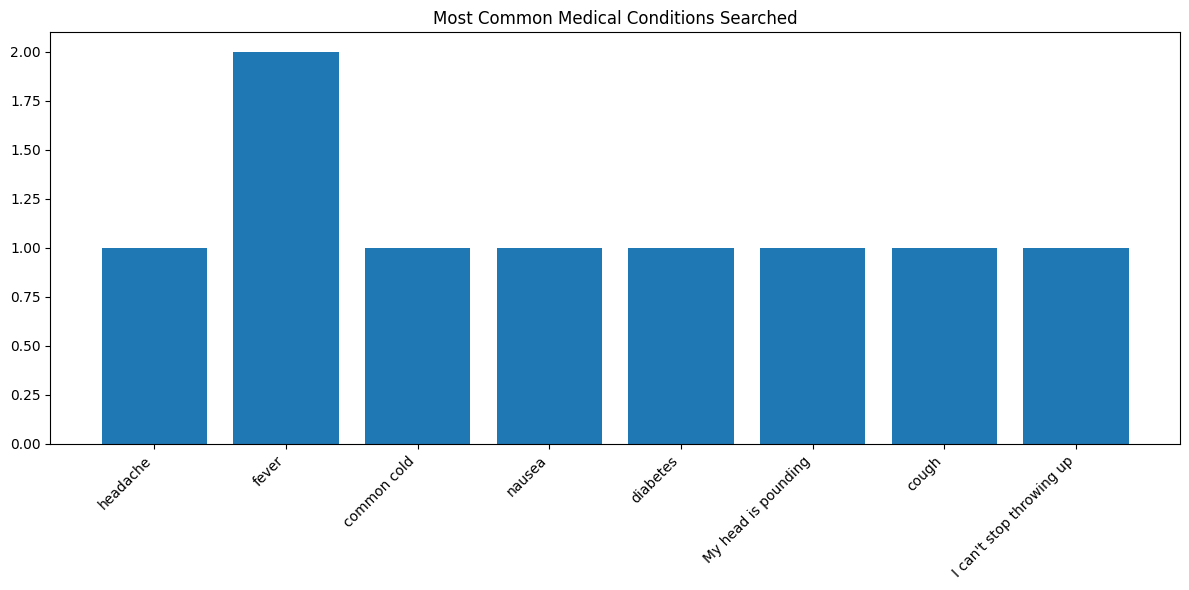

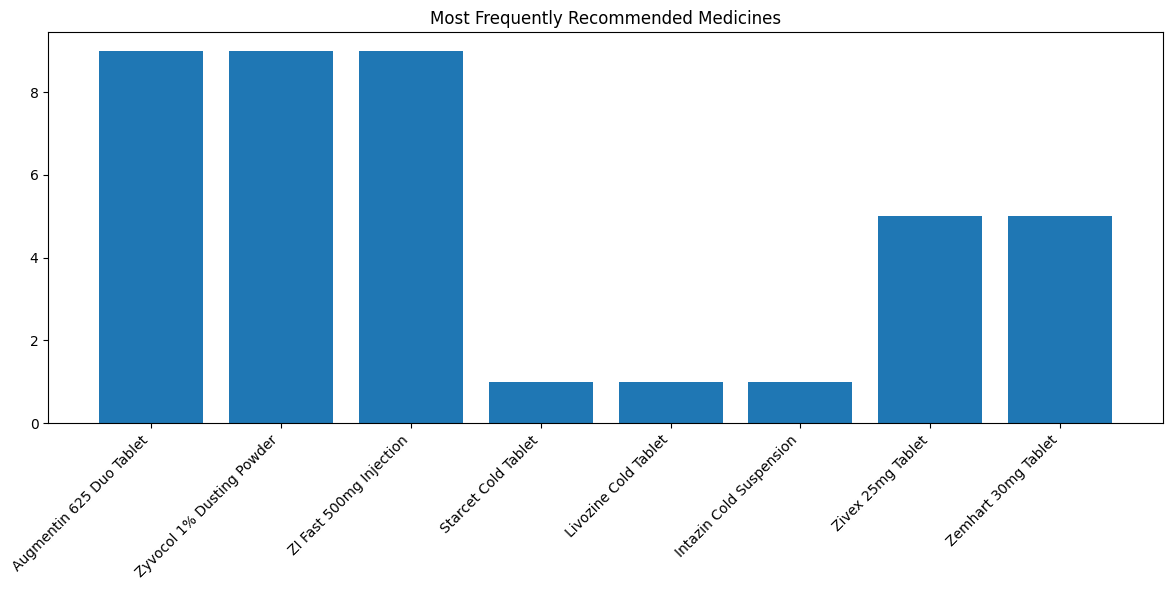

In [51]:
import matplotlib.pyplot as plt

if condition_counts and medicine_mentions:
    plt.figure(figsize=(12, 6))
    conditions = list(condition_counts.keys())[:8]
    counts = [condition_counts[c] for c in conditions]
    plt.bar(conditions, counts)
    plt.title('Most Common Medical Conditions Searched')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    medicines = list(medicine_mentions.keys())[:8]
    counts = [medicine_mentions[m] for m in medicines]
    plt.bar(medicines, counts)
    plt.title('Most Frequently Recommended Medicines')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [72]:
def evaluate_condition_extraction():
    test_cases = create_test_dataset()
    
    y_true = []
    y_pred = []
    
    print("Evaluating condition extraction accuracy:")
    for case in test_cases:
        query = case["query"]
        expected = case["expected_condition"]
        predicted = extract_condition(query)
        
        y_true.append(expected)
        y_pred.append(predicted)
        
        print(f"Query: '{query}'")
        print(f"  Expected: '{expected}'")
        print(f"  Predicted: '{predicted}'")
        print(f"  Correct: {expected == predicted}")
        print()
    
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Overall accuracy: {accuracy:.4f}")
    
    return accuracy

In [73]:
condition_extraction_accuracy = evaluate_condition_extraction()

Evaluating condition extraction accuracy:
Query: 'I have a headache'
  Expected: 'headache'
  Predicted: 'headache'
  Correct: True

Query: 'My head hurts'
  Expected: 'headache'
  Predicted: 'My head hurts'
  Correct: False

Query: 'I have fever and chills'
  Expected: 'fever'
  Predicted: 'fever'
  Correct: True

Query: 'I'm feeling hot and my temperature is high'
  Expected: 'fever'
  Predicted: 'I'm feeling hot and my temperature is high'
  Correct: False

Query: 'I can't stop coughing'
  Expected: 'cough'
  Predicted: 'cough'
  Correct: True

Query: 'I've been coughing all day'
  Expected: 'cough'
  Predicted: 'cough'
  Correct: True

Query: 'I feel nauseated'
  Expected: 'nausea'
  Predicted: 'nausea'
  Correct: True

Query: 'I'm about to throw up'
  Expected: 'vomiting'
  Predicted: 'I'm about to throw up'
  Correct: False

Query: 'I have diabetes'
  Expected: 'diabetes'
  Predicted: 'diabetes'
  Correct: True

Query: 'My blood sugar is high'
  Expected: 'diabetes'
  Predicted: 

In [56]:
def evaluate_medicine_recommendations():
    test_conditions = ["headache", "fever", "cough", "nausea", "diabetes"]
    results = {}
    
    print("Evaluating medicine recommendations relevance:")
    for condition in test_conditions:
        print(f"\nCondition: {condition}")
        recommendations = recommender.recommend_for_condition(condition, top_n=5)
        
        # Print top recommendations
        print("Top recommended medicines:")
        for i, rec in enumerate(recommendations, 1):
            print(f"{i}. {rec['medicine']} (Score: {rec['similarity_score']:.4f})")
            
        # Store average similarity score as a proxy for relevance
        avg_similarity = sum(rec['similarity_score'] for rec in recommendations) / len(recommendations)
        results[condition] = {
            "avg_similarity": avg_similarity,
            "top_medicine": recommendations[0]['medicine'] if recommendations else "None"
        }
    
    # Calculate overall average similarity
    overall_avg_similarity = sum(res["avg_similarity"] for res in results.values()) / len(results)
    print(f"\nOverall average similarity score: {overall_avg_similarity:.4f}")
    
    return results, overall_avg_similarity

In [57]:
def evaluate_end_to_end_pipeline():
    test_queries = [
        "I have a terrible headache",
        "I've been having a fever since yesterday",
        "My child has been coughing all night",
        "I feel nauseated after eating",
        "My blood sugar is high"
    ]
    
    print("End-to-end evaluation:")
    for query in test_queries:
        try:
            # Get recommendations
            start_time = time.time()
            result = get_recommendations(query)
            end_time = time.time()
            
            # Print results
            print(f"\nQuery: '{query}'")
            print(f"Identified condition: '{result['identified_condition']}'")
            print(f"Top recommendation: {result['recommendations'][0]['medicine']}")
            print(f"Processing time: {(end_time - start_time):.4f} seconds")
            
            # Try to get enhanced recommendation
            try:
                enhanced = enhance_recommendations_with_llm(query, result['recommendations'])
                if 'llm_response' in enhanced and enhanced['llm_response']:
                    print("LLM enhancement: Success")
                else:
                    print("LLM enhancement: Failed or empty response")
            except Exception as e:
                print(f"LLM enhancement error: {str(e)}")
                
        except Exception as e:
            print(f"Error processing query '{query}': {str(e)}")
    
    print("\nEnd-to-end pipeline evaluation complete.")

In [58]:
import time
evaluate_end_to_end_pipeline()

End-to-end evaluation:

Query: 'I have a terrible headache'
Identified condition: 'headache'
Top recommendation: Augmentin 625 Duo Tablet
Processing time: 0.1768 seconds
LLM enhancement: Success

Query: 'I've been having a fever since yesterday'
Identified condition: 'fever'
Top recommendation: Augmentin 625 Duo Tablet
Processing time: 0.2976 seconds
LLM enhancement: Success

Query: 'My child has been coughing all night'
Identified condition: 'cough'
Top recommendation: Augmentin 625 Duo Tablet
Processing time: 0.2409 seconds
LLM enhancement: Success

Query: 'I feel nauseated after eating'
Identified condition: 'nausea'
Top recommendation: Augmentin 625 Duo Tablet
Processing time: 0.2678 seconds
LLM enhancement: Success

Query: 'My blood sugar is high'
Identified condition: 'My blood sugar is high'
Top recommendation: Rgnil Syrup
Processing time: 0.2641 seconds
LLM enhancement: Success

End-to-end pipeline evaluation complete.


In [61]:
def display_model_metrics():
    print("=" * 50)
    print("MODEL EVALUATION METRICS")
    print("=" * 50)
    
    print(f"\nCondition extraction accuracy: {condition_extraction_accuracy:.4f}")
    
    # Make sure recommendation_score exists or provide a default
    recommendation_avg_score = recommendation_score if 'recommendation_score' in globals() else 0.0
    print(f"Recommendation relevance score: {recommendation_avg_score:.4f}")
    
    print("\nTop recommendations by condition:")
    for condition, result in recommendation_results.items():
        print(f"- {condition}: {result['top_medicine']} (Avg similarity: {result['avg_similarity']:.4f})")
    
    print("\nNote on metrics:")
    print("1. Condition extraction accuracy measures how well the system identifies medical conditions from queries.")
    print("2. Recommendation relevance score is the average similarity between queries and recommended medicines.")
    print("3. Higher scores indicate better performance for both metrics.")
    
    print("\nLimitations:")
    print("- These metrics are based on a limited test set and may not represent real-world performance.")
    print("- The recommendation relevance score is a proxy measure and doesn't guarantee clinical appropriateness.")
    print("- A medical professional should always be consulted for actual treatment decisions.")
    
    print("=" * 50)

In [62]:
display_model_metrics()

MODEL EVALUATION METRICS

Condition extraction accuracy: 0.5333
Recommendation relevance score: 0.0000

Top recommendations by condition:


NameError: name 'recommendation_results' is not defined